# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

16208


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5
import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook and chromosome size

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Chromosome size and median distances

## load median map


Data below can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [9]:
# load main folder
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\jie_CW_decode\postanalysis_v2CW_sorted'

# subclass to median distance dict
class_2_median_filename = os.path.join(postanalysis_folder, 'subclass_2_medianDict.pkl')
if os.path.exists(class_2_median_filename):
    print("Loading median")
    class_2_medianDict = pickle.load(open(class_2_median_filename, 'rb'))

Loading median


## load median summary

Data summary can be generated from the notebook as:

[1_cis_distance_summary_across_celltypes](1_cis_distance_summary_across_celltypes.ipynb)

In [10]:
import tqdm

distmap_summary_df_list = []
for _class in tqdm.tqdm(class_2_medianDict.keys()):
    _class_distmap_summary_df = pd.read_csv(os.path.join(output_analysis_folder,'Cis_dismap_summary',
                                                  f'raw_cis_distmap_subclass_{_class.replace("/","_").replace(" ","_")}_summary.csv'),
                                           index_col=0)
    distmap_summary_df_list.append(_class_distmap_summary_df)
    
distmap_summary_df = pd.concat(distmap_summary_df_list)
distmap_summary_df

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.61it/s]


,loc_1,loc_2,pairwise_distance,subclass,chr,genomic_distance
loci_pairs,,,,,,
0,chr1_3742742_3759944,chr1_3742742_3759944,0.000000,Oligo,1,0
1,chr1_3742742_3759944,chr1_6245958_6258969,0.922651,Oligo,1,2503216
2,chr1_3742742_3759944,chr1_8740008_8759916,1.070654,Oligo,1,4997266
3,chr1_3742742_3759944,chr1_9627926_9637875,1.060591,Oligo,1,5885184
4,chr1_3742742_3759944,chr1_9799472_9811359,1.093519,Oligo,1,6056730
...,...,...,...,...,...,...
2223475,chrX_167157164_167167452,chrX_169963295_170005197,0.845943,VLMC,X,2806131
2223476,chrX_168746045_168757590,chrX_168746045_168757590,0.000000,VLMC,X,0
2223477,chrX_168746045_168757590,chrX_169963295_170005197,0.706862,VLMC,X,1217250


## inspect pairwsie distance scatter between celltypes 

In [11]:
from sklearn.linear_model import LinearRegression

r2=0.65
(0.0, inf)
fraction below 1 -188992.9 %
fraction above 1 -1823356.9 %
(10000000, inf)
fraction below 1 97.6 %
fraction above 1 2.4 %
(0, 2000000)
fraction below 1 25.2 %
fraction above 1 74.8 %


meta NOT subset; don't know how to subset; dropped


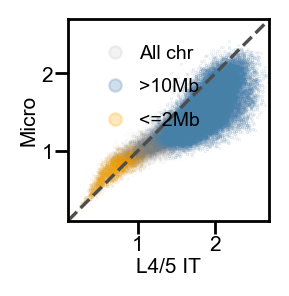

In [25]:
%matplotlib inline
import tqdm

sel_sorted_bin_keys = [(0., np.inf),(10000000, np.inf),(0, 2000000)]
color_list = ['gray','steelblue','orange',]



ref_cls = 'L4/5 IT'

#for sel_cls_2 in class_2_medianDict.keys():
for sel_cls_2 in ['Micro']:
    #ax = plt.subplot(grid[_chr_idx])
    fig, ax = plt.subplots(figsize=(_page_width/4.7,_page_width/4.7),dpi=200)
    #fig, ax = plt.subplots(figsize=(4,4),dpi=100)
    
    # annotate by different genomic distance
    for _idx,_bin_key in enumerate(sel_sorted_bin_keys):
            
        short_gd_th = _bin_key[0]
        long_gd_th = _bin_key[1]
        sel_distmap_summary_df = distmap_summary_df[(distmap_summary_df['genomic_distance']<=long_gd_th)&
                                            (distmap_summary_df['genomic_distance']>short_gd_th)]

        X = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==ref_cls]['pairwise_distance'].tolist())
        y = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==sel_cls_2]['pairwise_distance'].tolist())
        # calculate correlation for all loci
        if _idx==0:
            valid_inds = (np.isfinite(X) & np.isfinite(y))
            #print(np.sum(valid_inds), _subcls_1)
            X = X[valid_inds,np.newaxis]
            y = y[valid_inds]
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            #ax.annotate(f'{round(reg.score(X, y),2)}')
            print(f'r2={round(reg.score(X, y),2)}')
            ax.scatter(X,y,s=.01,alpha=0.1,color=color_list[_idx],label=f'All chr',rasterized=True)
        elif _idx==1:
            ax.scatter(X,y,s=.01,alpha=0.25,color=color_list[_idx],label='>10Mb',rasterized=True)
        elif _idx==2:
            ax.scatter(X,y,s=.01,alpha=0.25,color=color_list[_idx],label='<=2Mb',rasterized=True)
            
        

        legend = ax.legend(frameon=False, handletextpad=0.001)
        for legend_handle in legend.legendHandles:
            #legend_handle._legmarker.set_markersize(1)
            legend_handle.set_sizes([20])
        # for legend text
        plt.setp(ax.get_legend().get_texts(), fontsize=f'{_font_size-0.5}') 
        
        # get percentage for each category
        print(_bin_key)
        print('fraction below 1',round(np.sum(X>y)/len(X)*100,1),'%')
        print('fraction above 1',round(np.sum(X<y)/len(X)*100,1),'%')
        

    ax.grid(False)
    ax.set_aspect('equal')
    plt.xlim([0.1,2.7])
    plt.ylim([0.1,2.7])
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    plt.tick_params(axis='y', rotation=0, pad =0.5, labelsize=_font_size) 
    # set xlabel
    #if _idx==len(sel_chrom_list)-1:
    ax.set_xlabel(f'{ref_cls}',fontsize=_font_size,labelpad=1)
    ax.tick_params(axis='x', rotation=0, pad =0.5, labelsize=_font_size) 
    #else:
        #ax.set_xlabel(f'',fontsize=15,labelpad=7)
        #ax.tick_params(axis='x', rotation=0, labelsize=13,length=0) 
    # set ylabel    
    #if _chr_idx==int((len(sel_chrom_list)-1)/2):
    ax.set_ylabel(f'{sel_cls_2}', fontsize=_font_size, labelpad=1)
    #else:
        #ax.set_ylabel(f'', fontsize=15, labelpad=7)

    #ax.set_title(f'Chr{chosen_chrom}', fontsize=15, pad=7)

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.05, right=0.95, top=0.98, bottom=0.12)
ref_cls=ref_cls.replace('/','_').replace(' ','_')
sel_cls_2=sel_cls_2.replace('/','_').replace(' ','_')
plt.savefig(os.path.join(output_figure_folder, f'Cis_pairwise_distance_scatter_all_chroms_{ref_cls}_{sel_cls_2}.pdf'), 
        transparent=True, dpi=300, bbox_inches='tight')

plt.show()

r2=0.82
(0.0, inf)
fraction below 1 -1246860.4 %
fraction above 1 -765489.4 %
(10000000, inf)
fraction below 1 91.9 %
fraction above 1 8.1 %
(0, 2000000)
fraction below 1 31.2 %
fraction above 1 68.8 %


meta NOT subset; don't know how to subset; dropped


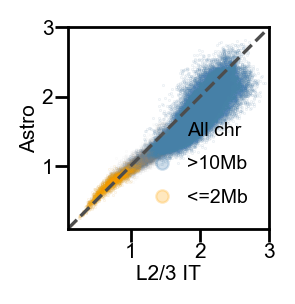

In [27]:
%matplotlib inline
import tqdm

sel_sorted_bin_keys = [(0., np.inf),(10000000, np.inf),(0, 2000000)]
color_list = ['gray','steelblue','orange',]



ref_cls = 'L2/3 IT'

#for sel_cls_2 in class_2_medianDict.keys():
for sel_cls_2 in ['Astro']:
    #ax = plt.subplot(grid[_chr_idx])
    fig, ax = plt.subplots(figsize=(_page_width/4.7,_page_width/4.7),dpi=200)
    #fig, ax = plt.subplots(figsize=(4,4),dpi=100)
    
    # annotate by different genomic distance
    for _idx,_bin_key in enumerate(sel_sorted_bin_keys):
            
        short_gd_th = _bin_key[0]
        long_gd_th = _bin_key[1]
        sel_distmap_summary_df = distmap_summary_df[(distmap_summary_df['genomic_distance']<=long_gd_th)&
                                            (distmap_summary_df['genomic_distance']>short_gd_th)]

        X = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==ref_cls]['pairwise_distance'].tolist())
        y = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==sel_cls_2]['pairwise_distance'].tolist())
        # calculate correlation for all loci
        if _idx==0:
            valid_inds = (np.isfinite(X) & np.isfinite(y))
            #print(np.sum(valid_inds), _subcls_1)
            X = X[valid_inds,np.newaxis]
            y = y[valid_inds]
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            #ax.annotate(f'{round(reg.score(X, y),2)}')
            print(f'r2={round(reg.score(X, y),2)}')
            ax.scatter(X,y,s=.01,alpha=0.1,color=color_list[_idx],label=f'All chr',rasterized=True)
        elif _idx==1:
            ax.scatter(X,y,s=.01,alpha=0.25,color=color_list[_idx],label='>10Mb',rasterized=True)
        elif _idx==2:
            ax.scatter(X,y,s=.01,alpha=0.25,color=color_list[_idx],label='<=2Mb',rasterized=True)
            
        

        legend = ax.legend(frameon=False, handletextpad=0.001)
        for legend_handle in legend.legendHandles:
            #legend_handle._legmarker.set_markersize(1)
            legend_handle.set_sizes([20])
        # for legend text
        plt.setp(ax.get_legend().get_texts(), fontsize=f'{_font_size-0.5}') 
        
        # get percentage for each category
        print(_bin_key)
        print('fraction below 1',round(np.sum(X>y)/len(X)*100,1),'%')
        print('fraction above 1',round(np.sum(X<y)/len(X)*100,1),'%')
        

    ax.grid(False)
    ax.set_aspect('equal')
    plt.xlim([0.1,3])
    plt.ylim([0.1,3])
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    plt.tick_params(axis='y', rotation=0, pad =0.5, labelsize=_font_size) 
    # set xlabel
    #if _idx==len(sel_chrom_list)-1:
    ax.set_xlabel(f'{ref_cls}',fontsize=_font_size,labelpad=1)
    ax.tick_params(axis='x', rotation=0, pad =0.5, labelsize=_font_size) 
    #else:
        #ax.set_xlabel(f'',fontsize=15,labelpad=7)
        #ax.tick_params(axis='x', rotation=0, labelsize=13,length=0) 
    # set ylabel    
    #if _chr_idx==int((len(sel_chrom_list)-1)/2):
    ax.set_ylabel(f'{sel_cls_2}', fontsize=_font_size, labelpad=1)
    #else:
        #ax.set_ylabel(f'', fontsize=15, labelpad=7)

    #ax.set_title(f'Chr{chosen_chrom}', fontsize=15, pad=7)

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.05, right=0.95, top=0.98, bottom=0.12)
ref_cls=ref_cls.replace('/','_').replace(' ','_')
sel_cls_2=sel_cls_2.replace('/','_').replace(' ','_')
plt.savefig(os.path.join(output_figure_folder, f'Cis_pairwise_distance_scatter_all_chroms_{ref_cls}_{sel_cls_2}.pdf'), 
        transparent=True, dpi=300, bbox_inches='tight')

plt.show()

## selected chromosome only

In [20]:
distmap_summary_df.head()

,loc_1,loc_2,pairwise_distance,subclass,chr,genomic_distance
loci_pairs,,,,,,
0,chr1_3742742_3759944,chr1_3742742_3759944,0.000000,Oligo,1,0
1,chr1_3742742_3759944,chr1_6245958_6258969,0.922651,Oligo,1,2503216
2,chr1_3742742_3759944,chr1_8740008_8759916,1.070654,Oligo,1,4997266
3,chr1_3742742_3759944,chr1_9627926_9637875,1.060591,Oligo,1,5885184
4,chr1_3742742_3759944,chr1_9799472_9811359,1.093519,Oligo,1,6056730


r2=0.76
(0.0, inf)
fraction below 1 872479.4 %
fraction above 1 290220.6 %
(10000000, inf)
fraction below 1 97.3 %
fraction above 1 2.7 %
(0, 2000000)
fraction below 1 14.8 %
fraction above 1 85.2 %


meta NOT subset; don't know how to subset; dropped


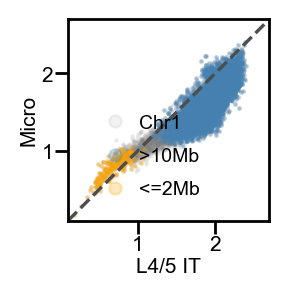

In [32]:
%matplotlib inline
import tqdm

sel_sorted_bin_keys = [(0., np.inf),(10000000, np.inf),(0, 2000000)]
color_list = ['gray','steelblue','orange',]


#fig, axes = plt.subplots(
                         #figsize=(4,4*len(sel_sorted_bin_keys)), 
                         #sharex=True, sharey=False, dpi=100)
#grid = plt.GridSpec(len(sel_sorted_bin_keys), 1,  hspace=0., wspace=0.)

chosen_chrom = '1'

ref_cls = 'L4/5 IT'

#for sel_cls_2 in class_2_medianDict.keys():
for sel_cls_2 in ['Micro']:
    #ax = plt.subplot(grid[_chr_idx])
    fig, ax = plt.subplots(figsize=(_page_width/4.7,_page_width/4.7),dpi=200)
    #fig, ax = plt.subplots(figsize=(4,4),dpi=100)
    
    # annotate by different genomic distance
    for _idx,_bin_key in enumerate(sel_sorted_bin_keys):
            
        short_gd_th = _bin_key[0]
        long_gd_th = _bin_key[1]
        sel_distmap_summary_df = distmap_summary_df[(distmap_summary_df['genomic_distance']<=long_gd_th)&
                                            (distmap_summary_df['genomic_distance']>short_gd_th)]
        
        sel_distmap_summary_df=sel_distmap_summary_df[sel_distmap_summary_df['chr']==chosen_chrom]

        X = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==ref_cls]['pairwise_distance'].tolist())
        y = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==sel_cls_2]['pairwise_distance'].tolist())
        # calculate correlation for all loci
        if _idx==0:
            valid_inds = (np.isfinite(X) & np.isfinite(y))
            #print(np.sum(valid_inds), _subcls_1)
            X = X[valid_inds,np.newaxis]
            y = y[valid_inds]
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            #ax.annotate(f'{round(reg.score(X, y),2)}')
            print(f'r2={round(reg.score(X, y),2)}')
            ax.scatter(X,y,s=1,alpha=0.1,color=color_list[_idx],label=f'Chr{chosen_chrom}',rasterized=True)
        elif _idx==1:
            ax.scatter(X,y,s=1,alpha=0.25,color=color_list[_idx],label='>10Mb',rasterized=True)
        elif _idx==2:
            ax.scatter(X,y,s=1,alpha=0.25,color=color_list[_idx],label='<=2Mb',rasterized=True)

        legend = ax.legend(frameon=False, handletextpad=0.001)
        for legend_handle in legend.legendHandles:
            #legend_handle._legmarker.set_markersize(1)
            legend_handle.set_sizes([20])
        # for legend text
        plt.setp(ax.get_legend().get_texts(), fontsize=f'{_font_size-0.5}') 
        
        # get percentage for each category
        print(_bin_key)
        print('fraction below 1',round(np.sum(X>y)/len(X)*100,1),'%')
        print('fraction above 1',round(np.sum(X<y)/len(X)*100,1),'%')
        

    ax.grid(False)
    ax.set_aspect('equal')
    plt.xlim([0.1,2.7])
    plt.ylim([0.1,2.7])
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    plt.tick_params(axis='y', rotation=0, pad =0.5, labelsize=_font_size) 
    # set xlabel
    #if _idx==len(sel_chrom_list)-1:
    ax.set_xlabel(f'{ref_cls}',fontsize=_font_size,labelpad=1)
    ax.tick_params(axis='x', rotation=0, pad =0.5, labelsize=_font_size) 
    #else:
        #ax.set_xlabel(f'',fontsize=15,labelpad=7)
        #ax.tick_params(axis='x', rotation=0, labelsize=13,length=0) 
    # set ylabel    
    #if _chr_idx==int((len(sel_chrom_list)-1)/2):
    ax.set_ylabel(f'{sel_cls_2}', fontsize=_font_size, labelpad=1)

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.05, right=0.95, top=0.98, bottom=0.12)
ref_cls=ref_cls.replace('/','_').replace(' ','_')
sel_cls_2=sel_cls_2.replace('/','_').replace(' ','_')
plt.savefig(os.path.join(output_figure_folder, f'Cis_pairwise_distance_scatter_chrom{chosen_chrom}_{ref_cls}_{sel_cls_2}.pdf'), 
        transparent=True, dpi=300, bbox_inches='tight')

plt.show()

r2=0.85
(0.0, inf)
fraction below 1 776377.1 %
fraction above 1 386322.9 %
(10000000, inf)
fraction below 1 92.9 %
fraction above 1 7.1 %
(0, 2000000)
fraction below 1 22.4 %
fraction above 1 77.6 %


meta NOT subset; don't know how to subset; dropped


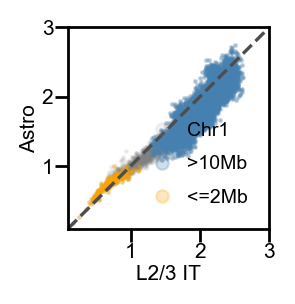

In [29]:
%matplotlib inline
import tqdm

sel_sorted_bin_keys = [(0., np.inf),(10000000, np.inf),(0, 2000000)]
color_list = ['gray','steelblue','orange',]


#fig, axes = plt.subplots(
                         #figsize=(4,4*len(sel_sorted_bin_keys)), 
                         #sharex=True, sharey=False, dpi=100)
#grid = plt.GridSpec(len(sel_sorted_bin_keys), 1,  hspace=0., wspace=0.)

chosen_chrom = '1'

ref_cls = 'L2/3 IT'

#for sel_cls_2 in class_2_medianDict.keys():
for sel_cls_2 in ['Astro']:
    #ax = plt.subplot(grid[_chr_idx])
    fig, ax = plt.subplots(figsize=(_page_width/4.7,_page_width/4.7),dpi=200)
    #fig, ax = plt.subplots(figsize=(4,4),dpi=100)
    
    # annotate by different genomic distance
    for _idx,_bin_key in enumerate(sel_sorted_bin_keys):
            
        short_gd_th = _bin_key[0]
        long_gd_th = _bin_key[1]
        sel_distmap_summary_df = distmap_summary_df[(distmap_summary_df['genomic_distance']<=long_gd_th)&
                                            (distmap_summary_df['genomic_distance']>short_gd_th)]
        
        sel_distmap_summary_df=sel_distmap_summary_df[sel_distmap_summary_df['chr']==chosen_chrom]

        X = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==ref_cls]['pairwise_distance'].tolist())
        y = np.array(sel_distmap_summary_df[sel_distmap_summary_df['subclass']==sel_cls_2]['pairwise_distance'].tolist())
        # calculate correlation for all loci
        if _idx==0:
            valid_inds = (np.isfinite(X) & np.isfinite(y))
            #print(np.sum(valid_inds), _subcls_1)
            X = X[valid_inds,np.newaxis]
            y = y[valid_inds]
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            #ax.annotate(f'{round(reg.score(X, y),2)}')
            print(f'r2={round(reg.score(X, y),2)}')
            ax.scatter(X,y,s=1,alpha=0.1,color=color_list[_idx],label=f'Chr{chosen_chrom}',rasterized=True)
        elif _idx==1:
            ax.scatter(X,y,s=1,alpha=0.25,color=color_list[_idx],label='>10Mb',rasterized=True)
        elif _idx==2:
            ax.scatter(X,y,s=1,alpha=0.25,color=color_list[_idx],label='<=2Mb',rasterized=True)

        legend = ax.legend(frameon=False, handletextpad=0.001)
        for legend_handle in legend.legendHandles:
            #legend_handle._legmarker.set_markersize(1)
            legend_handle.set_sizes([20])
        # for legend text
        plt.setp(ax.get_legend().get_texts(), fontsize=f'{_font_size-0.5}') 
        
        # get percentage for each category
        print(_bin_key)
        print('fraction below 1',round(np.sum(X>y)/len(X)*100,1),'%')
        print('fraction above 1',round(np.sum(X<y)/len(X)*100,1),'%')
        

    ax.grid(False)
    ax.set_aspect('equal')
    plt.xlim([0.1,3])
    plt.ylim([0.1,3])
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    plt.tick_params(axis='y', rotation=0, pad =0.5, labelsize=_font_size) 
    # set xlabel
    #if _idx==len(sel_chrom_list)-1:
    ax.set_xlabel(f'{ref_cls}',fontsize=_font_size,labelpad=1)
    ax.tick_params(axis='x', rotation=0, pad =0.5, labelsize=_font_size) 
    #else:
        #ax.set_xlabel(f'',fontsize=15,labelpad=7)
        #ax.tick_params(axis='x', rotation=0, labelsize=13,length=0) 
    # set ylabel    
    #if _chr_idx==int((len(sel_chrom_list)-1)/2):
    ax.set_ylabel(f'{sel_cls_2}', fontsize=_font_size, labelpad=1)

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.05, right=0.95, top=0.98, bottom=0.12)
ref_cls=ref_cls.replace('/','_').replace(' ','_')
sel_cls_2=sel_cls_2.replace('/','_').replace(' ','_')
plt.savefig(os.path.join(output_figure_folder, f'Cis_pairwise_distance_scatter_chrom{chosen_chrom}_{ref_cls}_{sel_cls_2}.pdf'), 
        transparent=True, dpi=300, bbox_inches='tight')

plt.show()